# Data Analysis of the GW170817 Event
We perfom data analysis to the GW data from GWOSC using the gwpy package and we present important results and fits.
## Package Import

In [304]:
# Common imports
import numpy as np
import scipy.integrate as integrate
from scipy.stats import linregress
import matplotlib.pyplot as plt
import wget
from matplotlib.cm import get_cmap   #gets a colour map with RC values

# gwpy imports
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.plot import Plot

from gwosc import datasets         
from gwpy.segments import Segment  #For Q transform

## General knowledge:
### Event
1. Data release for event GW170817. https://www.gw-openscience.org/events/GW170817/
2. Properties of the Binary Neutron Star Merger GW170817. https://journals.aps.org/prx/abstract/10.1103/PhysRevX.9.011001
3. GW170817: Observation of Gravitational Waves from a Binary Neutron Star Inspiral. https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.161101
* **Summary of the event:** GW170817: OBSERVATION OF GRAVITATIONAL WAVES FROM A BINARY NEUTRON STAR INSPIRAL. https://www.ligo.org/science/Publication-GW170817BNS/index.php

### Literature 
4. Constraining neutron star tidal Love numbers with gravitational wave detectors. https://arxiv.org/abs/0709.1915
5. Calibration Uncertainty for Advanced LIGO’s First and Second Observing Runs. https://dcc.ligo.org/public/0125/P1600139/016/UncertaintyMethodsPaper.pdf
* Extra
    6. Measurability of the tidal polarizability of neutron stars in late-inspiral gravitational-wave signals. https://arxiv.org/pdf/1203.4352.pdf


# GWSOC Data
1. Data source: https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW170817/v3
2. Gravitational-Wave Transient Catalog-1 Documentation: https://www.gw-openscience.org/GWTC-1/
3. GW170814: A Three-Detector Observation of Gravitational Waves from a Binary Black Hole Coalescence. https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.141101

## 1. Download Data

In [742]:
# Find the right central gps time
gps = datasets.event_gps('GW170817')
start = int(gps) - 20               ### Significant data is recorded for a span of apporximately 100 seconds, we will use +/- 10 due to memory usage     
end = int(gps) + 10

# Download the data from the merging neutron stars
l_raw = TimeSeries.fetch_open_data('L1', start, end)
h_raw = TimeSeries.fetch_open_data('H1', start, end)

#V1 = TimeSeries.fetch_open_data('V1', start, end)      ### VIRGO

* Signal ended at 12∶41:04.4 UTC
* 1.7 seconds after the event was observed, a gamma-ray burst was detected at the Fermi-GBM

## 2. Apply Filtering Techniques & Plot

In [743]:
# Whiten data
l_whiten = l_raw.whiten()
h_whiten = h_raw.whiten()
#V_whiten = V1.whiten()

# Bandpass filter
bp = filter_design.bandpass(20, 2000, h_raw.sample_rate) ### Supress large fluctuations around the detector sensitive band (From reference 3).

# Notch filter
notch = [filter_design.notch(f_line, h_raw.sample_rate) for f_line in (60, 120)]

# Concatenate filters and create 
t_fil = filter_design.concatenate_zpks(bp, *notch)

# Apply filter
l_data = l_whiten.filter(t_fil, filtfilt=True)
h_data = h_whiten.filter(t_fil, filtfilt=True)

#v_data = v_whiten.filter(t_fil, filtfilt=True)

C:\Users\erick\anaconda3\lib\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)
C:\Users\erick\anaconda3\lib\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


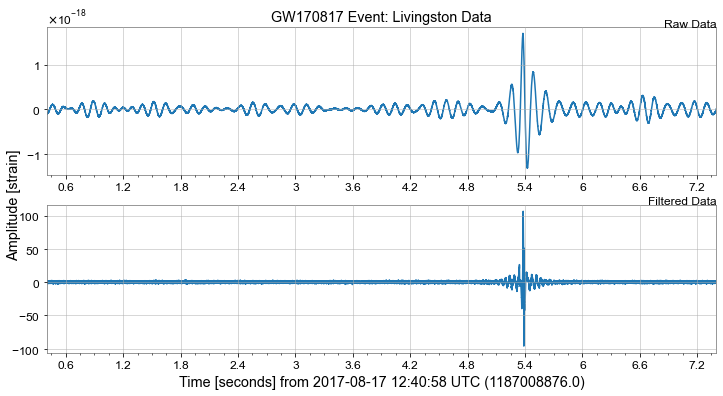

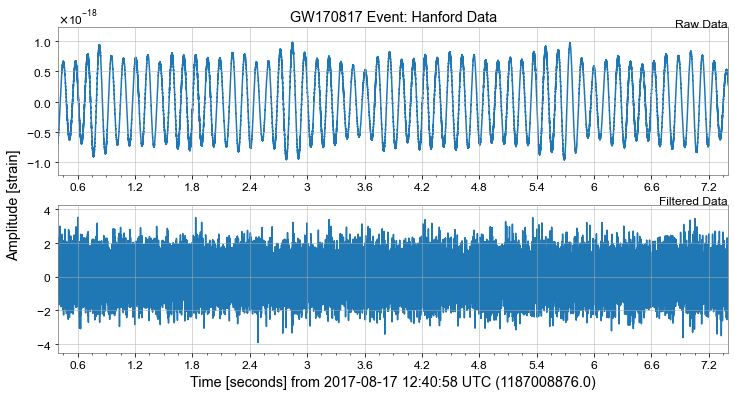

In [744]:
# Plot
## Livingston
plot = Plot(l_raw, l_data, separate=True, sharex=True)
ax1, ax2 = plot.axes
ax1.set_title("GW170817 Event: Livingston Data")
ax1.text(1.0, 1, 'Raw Data', transform=ax1.transAxes, ha='right')
ax2.text(1.0, 1, 'Filtered Data', transform=ax2.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax1.set_xlim(gps-6, gps+1) 
ax2.set_xlim(gps-6, gps+1) 
plot.show()

##  Hanford
plot = Plot(h_raw, h_data, separate=True, sharex=True)
ax1, ax2 = plot.axes
ax1.set_title("GW170817 Event: Hanford Data")
ax1.text(1.0, 1, 'Raw Data', transform=ax1.transAxes, ha='right')
ax2.text(1.0, 1, 'Filtered Data', transform=ax2.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax1.set_xlim(gps-6, gps+1) 
ax2.set_xlim(gps-6, gps+1)
plot.show()


By observing the time range $[gps-6, gps+1]$, it can be seen that the Livingston strain data has a spike in amplitude which is identified as a glitch. The glitch occured 1.1 seconds before the coalescence of the BNS.

# Q-Transform
## 1. Find the Q_gram

In [745]:
#Q-Transform the data using the "q_gram" function and scan over the time-frequency planes 
search = Segment(gps-0.5, gps+0.5)  ### Defines semi open interval for range (combining/overlapping segments)

# Find the Q_transform using the "q_gram" function
l_qgram = l_data.q_gram(qrange=(4, 150), search=search, mismatch=0.2) # mismatch 0.2 or keep 0.35
h_qgram = h_data.q_gram(qrange=(4, 150), search=search, mismatch=0.35)

## 2. Plot the Q-transforms

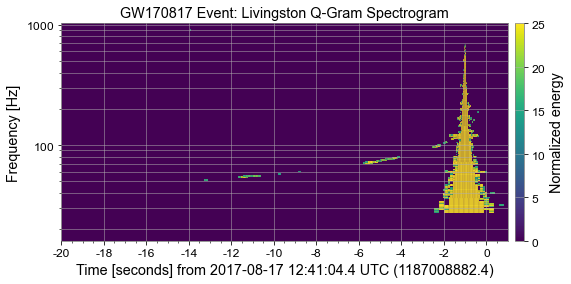

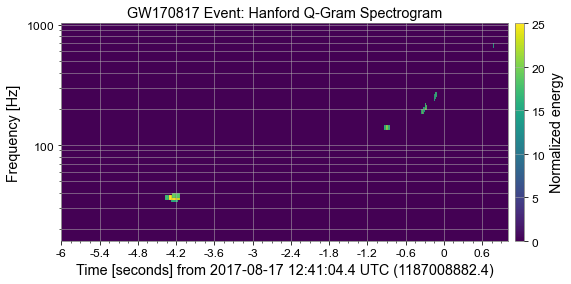

In [746]:
# Plot the loudest time-frequency plane
## Livingston
cmap = get_cmap('viridis')
plot = l_qgram.tile('time', 'frequency', 'duration', 'bandwidth', color='energy', 
                    figsize=[8,4], linewidth=0.1, edgecolor=cmap(0), antialiased=True)
ax = plot.gca()
ax.set_title("GW170817 Event: Livingston Q-Gram Spectrogram")
ax.set_xscale('seconds')
ax.set_xlim(gps-20, gps+1)
ax.set_epoch(gps)
ax.set_yscale('log')
ax.set_ylim(16, 1024)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])
cmap = get_cmap('viridis')
ax.set_facecolor(cmap(0))
plot.show()

## Hanford
cmap = get_cmap('viridis')
plot = h_qgram.tile('time', 'frequency', 'duration', 'bandwidth', color='energy',
                  figsize=[8,4], linewidth=0.1, edgecolor=cmap(0), antialiased=True)
ax = plot.gca()
ax.set_title("GW170817 Event: Hanford Q-Gram Spectrogram")
ax.set_xscale('seconds')
ax.set_xlim(gps-6, gps+1)
ax.set_epoch(gps)
ax.set_yscale('log')
ax.set_ylim(16, 1024)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])
cmap = get_cmap('viridis')
ax.set_facecolor(cmap(0))
plot.show()

It is evident again that the Livingston spectrogram contains a significant glitch.

Furthermore, it can be seen that the Virgo spectrogram does not contain enough significant data, this is due to its low BNS Horizon and direction of the GW source with respect to the detector. We can conclude that the virgo data is unsuitable for the rest of the analysis on this project.

## 3.  Glitch Removal from the Livingston Data
Explain how:

**Inverse Discrete Wavelet Transform (IDWT), used for reference 3)** https://pywavelets.readthedocs.io/en/latest/ref/idwt-inverse-discrete-wavelet-transform.html#inverse-discrete-wavelet-transform-idwt

**Resources**
* Mitigation of the instrumental noise transient in gravitational-wave data surrounding GW170817. https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.084016
* Subtracting glitches from gravitational-wave detector data during the third LIGO-Virgo observing run. https://iopscience.iop.org/article/10.1088/1361-6382/aca238/meta
* Glitch subtraction from gravitational wave data using adaptive spline fitting. https://arxiv.org/pdf/2301.02398.pdf

### 3.1 Method 1

In [212]:
# Obtain the average + amplitude of the peaks.
max_amp = []
for i in range(1, len(l_data)-1):
    if (l_data[i] > l_data[i-1]) and (l_data[i] > l_data[i+1]):
        max_amp.append(l_data[i]) 

In [213]:
# Obtain the average + amplitude of the peaks.
min_amp = []
for i in range(1, len(l_data)-1):
    if (l_data[i] < l_data[i-1]) and (l_data[i] < l_data[i+1]):
        min_amp.append(l_data[i])

In [214]:
# Average the amplitudes
avg_max = np.mean(max_amp)
avg_min = np.mean(min_amp)

print(avg_max,avg_min)

0.7832473913007713 -0.7900414738322514


C:\Users\erick\anaconda3\lib\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


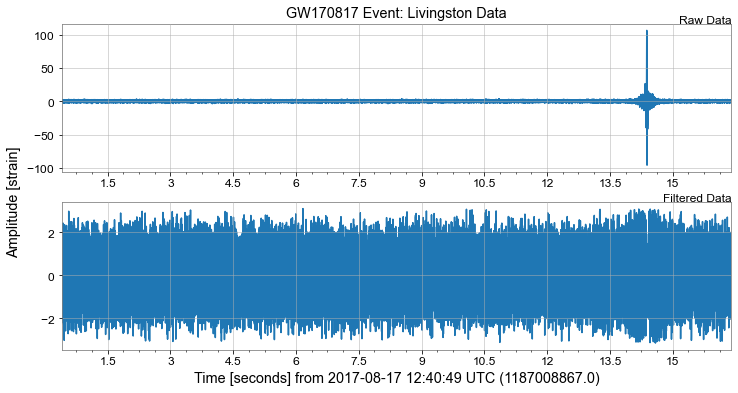

In [747]:
import numpy as np
# Data
l_new_data = l_data.copy()

# Store cause it takes a while
mxx = 0.7832473913007713    # Previous avg:  0.5524631554748616
mnn = -0.7900414738322514   # Previous avg: -0.5700878381661025

# Apply a gain
max_gain = 4 * mxx
min_gain = 4 * mnn  

# Extract the data to evaluate the threshold condition
l_zip = l_new_data.zip() # Zips the data and "solves" the problem of data storage (for now)

# Apply a threshold to the data
l_new_data[l_zip[0: , 1] > max_gain] = 0
l_new_data[l_zip[0: , 1] < min_gain] = 0

# Plot
## Livingston
plot = Plot(l_data, l_new_data, separate=True, sharex=True)
ax1, ax2 = plot.axes
ax1.set_title("GW170817 Event: Livingston Data")
ax1.text(1.0, 1, 'Raw Data', transform=ax1.transAxes, ha='right')
ax2.text(1.0, 1, 'Filtered Data', transform=ax2.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax1.set_xlim(gps-15, gps+1) 
ax2.set_xlim(gps-15, gps+1) 
plot.show()

* The method doesnt work because of the way that the TimeSeries data is stored!! I got to the same problem I had when calculating the ASD
    * **Error:** TypeError: no implementation found for 'numpy.all' on types that implement __array_function__: [<class 'gwpy.timeseries.statevector.StateTimeSeries'>]
    
* Look into:
    * https://gwpy.github.io/docs/stable/api/gwpy.timeseries.StateTimeSeries/#gwpy.timeseries.StateTimeSeries
    * https://gwpy.github.io/docs/stable/timeseries/statevector/

## 4. Plotting Livingston Spectrogram without the Glitch

In [748]:
# Find the Q_transform using the "q_gram" function
l_qgram_new = l_new_data.q_gram(qrange=(4, 150), search=search, mismatch=0.35) # mismatch 0.2 or keep 0.35

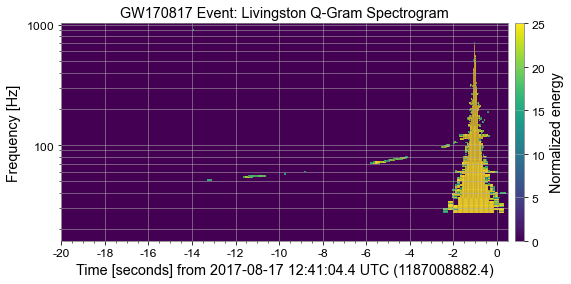

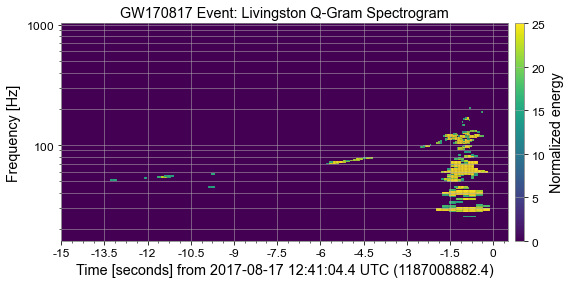

In [749]:
# Plot the loudest time-frequency plane
## Glitch
cmap = get_cmap('viridis')
plot = l_qgram.tile('time', 'frequency', 'duration', 'bandwidth', color='energy', 
                    figsize=[8,4], linewidth=0.1, edgecolor=cmap(0), antialiased=True)
ax = plot.gca()
ax.set_title("GW170817 Event: Livingston Q-Gram Spectrogram")
ax.set_xscale('seconds')
ax.set_xlim(gps-20, gps+0.5)
ax.set_epoch(gps)
ax.set_yscale('log')
ax.set_ylim(16, 1024)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])
cmap = get_cmap('viridis')
ax.set_facecolor(cmap(0))
plot.show()

## No Glitch
cmap = get_cmap('viridis')
plot = l_qgram_new.tile('time', 'frequency', 'duration', 'bandwidth', color='energy', 
                    figsize=[8,4], linewidth=0.1, edgecolor=cmap(0), antialiased=True)
ax = plot.gca()
ax.set_title("GW170817 Event: Livingston Q-Gram Spectrogram")
ax.set_xscale('seconds')
ax.set_xlim(gps-15, gps+0.5)
ax.set_epoch(gps)
ax.set_yscale('log')
ax.set_ylim(16, 1024)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])
cmap = get_cmap('viridis')
ax.set_facecolor(cmap(0))
plot.show()

# Data Extraction
## 1. Extracting the Frequency

In [750]:
import pandas as pd
# Convert qgram data to DF 
l_df = l_qgram_new.to_pandas()

h_df = h_qgram.to_pandas()

# Merge data frames
data_df = pd.concat([l_df, h_df])

# Assign variables to the columns of the data frame for convenience
data_df['time'] = data_df['time'] - gps

# Remove the outliers of the data by applying threshold in the time column of the df
data_df = data_df.query('time < 0 & time > -15 & frequency < 300')  # Check again if the outliers outside should be removed or not!!

# Sort columns and reset index
data_df = data_df.sort_values(['time'], ignore_index=True)

    
# Assign variables to the time and frequency
data_t = data_df['time']
data_freq = data_df['frequency']

# Display Data Frame
display(data_df)

,time,frequency,duration,bandwidth,energy
0,-13.251563,51.266667,0.117188,1.905911,15.249010
1,-13.134375,51.266667,0.117188,1.905911,15.668280
2,-12.079688,53.533333,0.117188,1.990178,15.580779
3,-11.610938,54.300000,0.117188,2.018680,16.633579
4,-11.493750,54.300000,0.117188,2.018680,22.652294
...,...,...,...,...,...
530,-0.141211,243.933333,0.014648,22.441224,15.138408
531,-0.141211,252.666667,0.014648,23.244668,16.262571
532,-0.126563,261.700000,0.014648,24.075711,17.159397
533,-0.126563,252.666667,0.014648,23.244668,16.008276


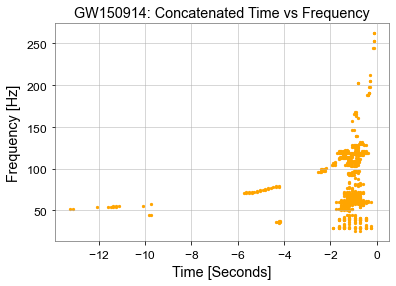

In [751]:
# Plot
## Complete data frame 
plt.scatter(data_t, data_freq, s=5, color='orange')
plt.title("GW150914: Concatenated Time vs Frequency")
plt.xlabel('Time [Seconds]')
plt.ylabel('Frequency [Hz]')
#plt.yscale('log')
plt.grid(True, axis='y', which='both')
plt.show()

## 2. Apply hand picked filter


In [784]:
# Remove the glitch data that wasnt removed by the other method
data_df1 = data_df.drop(data_df[((data_df.time.between(-2, 0)) & (data_df.frequency.between(0, 100))) | 
                                ((data_df.time > -1.45) & (data_df.frequency < 122)) | 
                                ((data_df.time > -1) & (data_df.frequency < 130))].index)

# Remove the final outliers
df_no_glitch = data_df1.drop(data_df1[((data_df1.time.between(-1.2, -.50)) & (data_df1.frequency > 139)) |
                                      ((data_df1.time > -10) & (data_df1.frequency < 50))].index)


display(df_no_glitch)
# Assign variables to the time and frequency
t_new = df_no_glitch['time']
freq_new = df_no_glitch['frequency']

# Assign variables to errors:
xerr = df_no_glitch['duration']
yerr = df_no_glitch['bandwidth']

xerr_lin = df_no_glitch['duration']**(-8/3)
yerr_lin = df_no_glitch['bandwidth']**(-8/3)



,time,frequency,duration,bandwidth,energy
0,-13.251563,51.266667,0.117188,1.905911,15.249010
1,-13.134375,51.266667,0.117188,1.905911,15.668280
2,-12.079688,53.533333,0.117188,1.990178,15.580779
3,-11.610938,54.300000,0.117188,2.018680,16.633579
4,-11.493750,54.300000,0.117188,2.018680,22.652294
...,...,...,...,...,...
530,-0.141211,243.933333,0.014648,22.441224,15.138408
531,-0.141211,252.666667,0.014648,23.244668,16.262571
532,-0.126563,261.700000,0.014648,24.075711,17.159397
533,-0.126563,252.666667,0.014648,23.244668,16.008276


Text(0, 0.5, 'Frequency [Hz]')

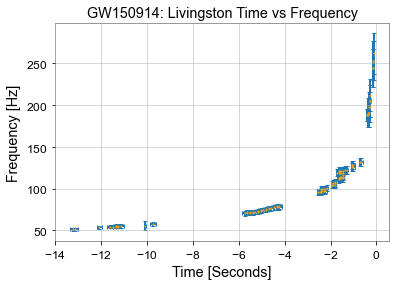

In [781]:
# Plot
plt.scatter(t_new, freq_new, s=1, color="orange")
plt.errorbar(t_new, freq_new, yerr, xerr,fmt = "none", lw=2, capsize=2, capthick=1,zorder=0)
plt.title("GW150914: Livingston Time vs Frequency")
plt.xlabel('Time [Seconds]')
plt.ylabel('Frequency [Hz]')
#plt.yscale('log')
#plt.xticks(np.arange(-2, max(t_new), 0.5))
#plt.yticks(np.arange(100, 150, 10))
#plt.grid(True, axis='y', which='both')

## 3. Linearize the Frequency 

In [700]:
# Add the linearized frequency
df_no_glitch["linearized frequency"] = df_no_glitch['frequency']**(-8/3) 

# Assign a variable to the linearized frequency
li_freq = df_no_glitch['linearized frequency']


In [793]:
sigma_t = xerr
sigma_f = li_freq*yerr

sigma_t = np.sqrt(sigma_t**2 + sigma_f**2)
print(sigma_t)

0      0.117188
1      0.117188
2      0.117188
3      0.117188
4      0.117188
         ...   
530    0.014648
531    0.014648
532    0.014648
533    0.014648
534    0.014648
Length: 96, dtype: float64


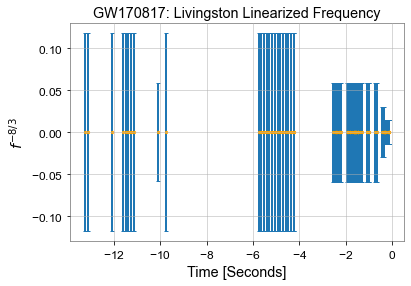

In [792]:
# Plot
plt.scatter(t_new, li_freq, s=5, color="orange")
plt.errorbar(t_new, li_freq, yerr=sigma_t, fmt = "none", lw=2, capsize=2, capthick=1,zorder=0)
plt.title("GW170817: Livingston Linearized Frequency")
plt.xlabel('Time [Seconds]')
plt.ylabel('$f^{-8/3}$')
plt.grid(True, axis='y', which='both')
plt.show()

### 2.1 Method 1:
Interpolate the linearized frequency by using 'splprep', which finds the B-spline representation of the data, and evaluating the polynomial using 'splev'
**Source:**
* scipy.interpolate.splprep: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splprep.html
  https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html#procedural-splrep
* scipy.interpolate.splev: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splev.html#scipy.interpolate.splev
  

In [702]:
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
# ------------------------------------------------------------------------------------------------------------------------------
# Assign a variable to the 'energy' column of the DF. This can be used as a weigth array for the interpolation
l_energy = df_no_glitch['energy']

# Find the b-spline (interpolation)
l_tck, l_u = interpolate.splprep([t_new, li_freq], w=l_energy, s=400) 

# Create a new array l_u with more points to evaluate the interpolation
#l_u = np.linspace(0, 1, num=100, endpoint=True)

# Evaluate the interpolations
l_interp = interpolate.splev(l_u, l_tck) 

# Calculate the standard error (since data is subject to uncertrainty)
## Frequency (y_axis)
plot_mse_f = np.sqrt((li_freq - l_interp[1])**2)
mse_interp = np.mean((li_freq - l_interp[1])**2)
se_f = np.sqrt(mse_interp/len(li_freq))

## Time (x_axis)
plot_mse_t = np.sqrt((t_new - l_interp[0])**2)
mse_x = np.mean((t_new - l_interp[0])**2)
se_t = np.sqrt(mse_x/len(t_new))
                
# ------------------------------------------------------------------------------------------------------------------------------
# Find and evaluate the derivative of the interpolations
#l_dev = interpolate.splev(l_u, l_tck, der=1)

# Find the Covariance Matrix and the Standard Deviations of the interpolations
#l_dev_cov = np.cov(l_dev, aweights=l_energy) 
#l_dev_sd = np.sqrt(np.diag(l_dev_cov))

# Print the variance results
print("The standard error of the linearized frequency is", se_f)
print("The standard error for the x-axis is", se_t)

The standard error of the linearized frequency is 3.033562723933584e-08
The standard error for the x-axis is 1.2387511790316674e-07


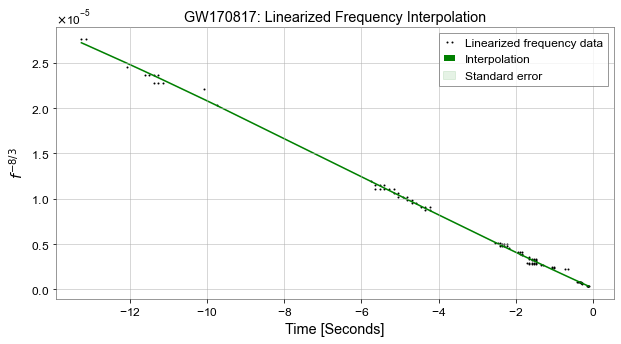

In [703]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_new, li_freq, 'ko',markersize=1, label = "Linearized frequency data")
ax.plot(l_interp[0], l_interp[1], 'g-', label = "Interpolation")
ax.fill_between(l_interp[0], l_interp[1] - se_f, l_interp[1] + se_f, alpha=0.1, edgecolor='g', facecolor='g', label = "Standard error")
plt.title("GW170817: Linearized Frequency Interpolation")
plt.ylabel('$f^{-8/3}$')
plt.xlabel('Time [Seconds]')
plt.grid(True, axis='y', which='both')
plt.legend(loc='best')

plt.show()

* The smoothing condition $s$ in the splprep function has to be used carefully since its a tradeoff between how accurate the interpolation is and how smooth it becomes. Further analysis on it is required.



* **(DATA IS MORE ACCURATE HERE - MAYBE DERIVATIVE WILL WORK NOW)**  It can be seen that taking the derivative of the interpolation results in an unexpected slope. After discussion among peers, it was concluded that it is poissible that $dev$ in the splev function is taking the derivative of the knots and coefficients of the splines rather than its output. 

### 2.2  Method 2: 'Cuve_fit'
Integrate the chirpmass equation $\dot{f} = \frac{96}{5} \pi^{8/3} (\frac{GM_{c}}{c^{3}})^{5/3} f^{11/3}$  with respect to time and fit f as a straight line $f(t) = at + b$ using the 'curvefit' function. Obtaining the following integral

$$\frac{3}{8} f^{-8/3} = - \frac{96}{5} \pi^{8/3} (\frac{GM_{c}}{c^{3}})^{5/3}t + b$$

where $a = - \frac{96}{5} \pi^{8/3} (\frac{GM_{c}}{c^{3}})^{5/3}$.

* Reconstruction of Chirp Mass in the Search of Compact Binaries: https://arxiv.org/abs/1510.02426

In [704]:
from scipy.optimize import curve_fit

# -------------------------------------------------------
# Add constant to the linearized frequency
li_freq2 = (3/8) * df_no_glitch['linearized frequency']

# Define fit function
def fit(t, a, b):
    return(a*t + b)

# Perform the lienar fit
l_popt_fit, l_pcov_fit = curve_fit(fit, t_new, li_freq2, sigma=1/l_energy)

# Find the standard deviations
l_fit_sd = np.sqrt(np.diag(l_pcov_fit))

# Print SD results
print("The variance of the {a} for the Livingston linearized frequency curve fit is:\n", l_pcov_fit[0][0], "\n")

# fit error
s_err = np.sqrt((t_new*l_fit_sd[0])**2 + l_fit_sd[1]**2)

The variance of the {a} for the Livingston linearized frequency curve fit is:
 1.4552707605869497e-17 



* For the plot, use the optimized time values from the interpolation to evaluate the fit 

C:\Users\erick\anaconda3\lib\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


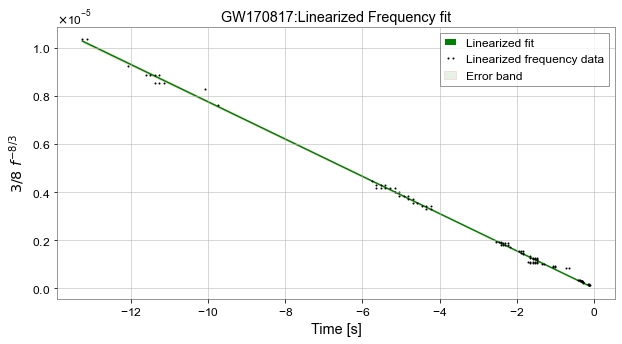

In [705]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_new, fit(t_new, *l_popt_fit), 'g-',markersize=2, label = "Linearized fit")
ax.plot(t_new, li_freq2, 'ko', markersize=1, label = "Linearized frequency data")
ax.fill_between(t_new, fit(t_new, *l_popt_fit) - s_err, fit(t_new, *l_popt_fit) + s_err,
                alpha=0.1, edgecolor='r', facecolor='g', label = "Error band")

ax.set_title("GW170817:Linearized Frequency fit")
ax.set_ylabel('$ 3/8 \ f^{-8/3} $')
ax.set_xlabel('Time [s]')
ax.grid(True, axis='y', which='both')
ax.legend(loc='best')

plot.show()

Knowing the extracted data from the event is not prefectly linear due to signal errors and different factors, we can conclude the following:

* Method 1 follows the data more proportionately, giving a fit that is closer to the true distribution. As a consequence, we lose a significant amount of accuracy, which is shown graphically with the standard devation interval shown in the figures.


* Method 2 provides an optimize curve that fits the data, which gives us an ideal fit that can match the theory but we lose information on the observation obtained by the LIGO experiment. Therefore, we can conclude that we lose information of the true distribtuion while we gain accuracy in our variance.

# Calculations/Analysis

## 1. Find the chirpmass 

### 1.1 Method 1: Interpolation

Using the interpolation fit, we calculate the slope of the interpolation and use it to calculate the chirp mass $M_{c}$. We obtain the following equation for the chirp mass by integrating the chirp mass equation given in *Observation of Gravitational Waves from a Binary Black Hole Merger* $M_{c} = \frac{c^{3}}{G} \left[ (\frac{5}{96})^{3} \pi^{-8/3} f^{-11/3} \dot f \right]^{1/5}$. Then we solve for $f^{-8/3}$ and differentiate with respect to time

$$ M_{c} = \frac{c^{3}}{G(8\pi)^{8/5}} (-5s)^{3/5}$$

Then, we propagate the uncertainty to the chirmass equation 

$$\sigma_{M} = \frac{\partial M}{\partial s} \sigma_{s} = M\frac{3\sigma_{s}}{5s}$$

  
Where $\sigma_{s}$ comes from the error propagation of the standard errors calculated for the interpolaton

$$\sigma_{s}^{2} = |\frac{\partial s}{\partial f}|^{2} \sigma_{f}^{2} + |\frac{\partial s}{\partial t}|^{2} \sigma_{t}^{2} + 2\frac{\partial s}{\partial f}\frac{\partial s}{\partial t}COV(f,t) $$

* Source: 
    1. [Observation of Gravitational Waves from a Binary Black Hole Merger.]( https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)
    2. https://colab.research.google.com/github/jkanner/aapt/blob/master/AAPT-WM19-Stuver.ipynb

In [706]:
from scipy import stats
# Define the constants
G = 6.67408e-11                 # In m**3 / (kg * s**2)
c = 299792458                   # In m/s
solar_mass = Msun = 1.989e+30   # In kg

# Get the slope of the linearized frequency
t_interp = l_interp[0]
f_interp = l_interp[1]
slope = np.gradient(f_interp,t_interp)

# Find the chirpmass
l_cm_kg = (c**3 / (G * (8*np.pi)**(8/5))) * np.sign(slope)*-(5 * (abs(slope)))**(3/5)
l_chirp_mass = np.mean(l_cm_kg/solar_mass)

l_plot_cm = l_cm_kg/solar_mass

# Propagation of errors

## Slope error
slope_err = np.sqrt((se_f / t_interp)**2 + (f_interp*se_t / t_interp**2)**2)

plot_slope_err = np.sqrt((plot_mse_f / t_interp)**2 + (f_interp*plot_mse_t / t_interp**2)**2)

## Chirp mass error
err_slope_cm = np.mean(abs(l_chirp_mass * (3*slope_err/(5*np.mean(slope)))))
var_slope_cm = err_slope_cm**2

plot_err_slope_cm = abs(l_chirp_mass * (3*plot_slope_err/(5*np.mean(slope))))

# Print results
print("The chirp mass using the Livingston data is", l_chirp_mass, u"\u00B1", err_slope_cm, "solar masses \n")
print("var:", var_slope_cm)

The chirp mass using the Livingston data is 1.1729843674553928 ± 0.012460492018524102 solar masses 

var: 0.00015526386134370287


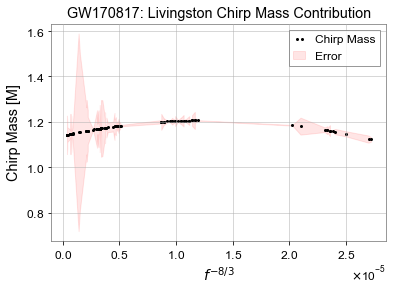

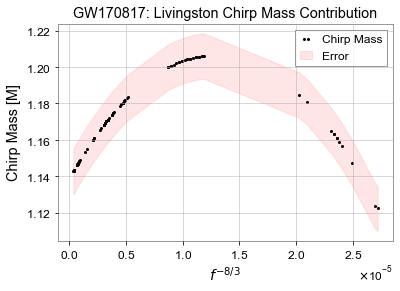

In [707]:
# Plot 
## Individual 
fig, ax = plt.subplots()
ax.plot(f_interp, l_plot_cm, 'ko', markersize=2, label = "Chirp Mass")
ax.fill_between(f_interp, l_plot_cm - plot_err_slope_cm, l_plot_cm + plot_err_slope_cm,
                alpha=0.1, edgecolor='r', facecolor='r', label = "Error")
ax.set_title("GW170817: Livingston Chirp Mass Contribution")
ax.set_ylabel('Chirp Mass [M]')
ax.set_xlabel('$f^{-8/3}$')
ax.grid(True, axis='y', which='both')
ax.legend(loc='best')

plt.show()

## Band
fig, ax = plt.subplots()
ax.plot(f_interp, l_plot_cm, 'ko', markersize=2, label = "Chirp Mass")
ax.fill_between(f_interp, l_plot_cm - err_slope_cm, l_plot_cm + err_slope_cm,
                alpha=0.1, edgecolor='r', facecolor='r', label = "Error")
ax.set_title("GW170817: Livingston Chirp Mass Contribution")
ax.set_ylabel('Chirp Mass [M]')
ax.set_xlabel('$f^{-8/3}$')
ax.grid(True, axis='y', which='both')
ax.legend(loc='best')

plt.show()

### 1.2 Method 2: Using Curve_fit Data
Given that $a = - \frac{96}{5} \pi^{8/3} (\frac{GM_{c}}{c^{3}})^{5/3}$ is one of the optimized parameters obtained with the 'curve_fit' function, we can use it to solve for the Chirp Mass by isolating $M_{c}$

$$ a = - \frac{96}{5} \pi^{8/3} (\frac{G}{c^{3}})^{5/3} M_{c}^{5/3} $$
$$ \Rightarrow M_{c} = (\frac{a}{a_{0}})^{3/5} $$

where $a_{0} = - \frac{96}{5} \pi^{8/3} (\frac{G}{c^{3}})^{5/3}$.

For the error propagation we have

$$\sigma_{M} = \frac{\partial M_{c}}{\partial a} \sigma_{a} = \frac{3 a^{-2/5}}{5a_{0}^{3/5}} \sigma_{a}$$

In [708]:
# Define constants assign variables to a
a0 = -(96/5) * np.pi**(8/3) * (G/(c**3))**(5/3)
l_a = l_popt_fit[0]

# Compute the chirp mass
l_cm_fit = (l_a/a0)**(3/5) / solar_mass

# Propagation of error
l_cm_sd_fit = (3 * np.sign(l_a)*abs(l_a)**(-2/5)) / (5 * np.sign(a0) * abs(a0)**(3/5)) * l_fit_sd[0] / solar_mass

l_cm_var_fit = l_cm_sd_fit**2

# Print results
print("The chirp mass is", l_cm_fit, u"\u00B1", l_cm_sd_fit, "solar masses \n")
print("Chirp mass variance:", l_cm_var_fit)

The chirp mass is 1.1897577677800253 ± 0.003515683409846557 solar masses 

Chirp mass variance: 1.2360029838270316e-05


## 2. Find the phase

### 2.2 Using the 'curve_fit' data

In [709]:
from scipy import integrate
# -------------------------
# Assign a variable to the frequency array obtained by the 'curve_fit' function
t = np.linspace(min(t_new), -0.05, num=200)
f_fit = fit(t, *l_popt_fit)

# Function that calculates the phase
def w(x):
    phase_m2 = np.zeros_like(x)
    for i, int_time in enumerate(x):
        if i > 0:
            y, err = integrate.quad(fit, a=t[0], b=int_time, 
                                    args=(l_popt_fit[0],l_popt_fit[1]))
            phase_m2[i] = (2*np.pi) * y
    return phase_m2

# Evaluate the integral 
l_phase_fit = w(t)  ## remove the * (8/3) and the **(-3/8) 


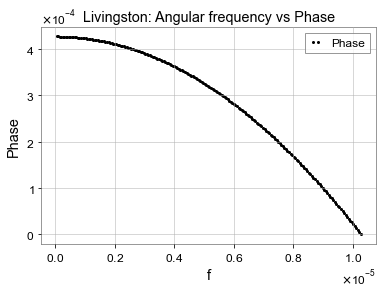

In [710]:
# Plot
## Livingston
fig, ax = plt.subplots()
ax.plot(f_fit, l_phase_fit, 'ko', markersize=2, label = "Phase")
#ax.fill_between(l_slope, l_plot_cm - l_chirp_mass_sd, l_plot_cm + l_chirp_mass_sd, alpha=0.1, edgecolor='g', facecolor='g', label = "Standard Deviation")
ax.set_title("Livingston: Angular frequency vs Phase")
ax.set_ylabel('Phase')
ax.set_xlabel('f')  ## $3/8f^{-8/3}$
ax.grid(True, axis='y', which='both')
ax.legend(loc='best')

plt.show()

## 3. Extract parameters using fit formula for phase
Having the phaser equations as a function of frequency

<img src="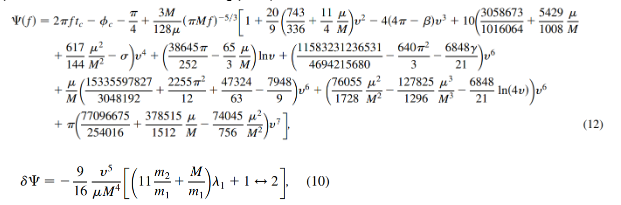  " />


Where $v = (\pi M f)^{1/3}$ and $\gamma$ is Euler's constant.
We obtain the complete phase equation by adding linearly the tidal term (2nd eq.) to the stationary phase approximation formula

By differentiating the exponent coefficients of the FT of the waveform $h(t) = \int_{-\infty}^{\infty} Af^{-7/6} e^{i\Psi(f) - i 2 \pi ft}df$

$$\frac{d}{df} \left( \Psi(f)-2\pi ft \right) = \frac{d\Psi}{df} - 2 \pi t = 0$$ 

$$\Rightarrow t = t_{c} + \frac{1}{2 \pi} \frac{d\Psi}{df}$$

where $t_{c}$ is the coalescence time (constant)

We can fit the complete derivative of the phase equation to obtain the **tidal deformability $\overset{\sim}{\lambda}$** of the system. Here, $\{\beta, \sigma, t_{c},\phi_{c}, M, \mu \}$ are free parameters of our fit where
* $\beta$ and $\sigma$ are spin parameters
* $\phi_{c}$ is the phase coalescence constant
* $M = \left[\frac{(1+q)^2}{q} \right]^{3/5} M_{c}$ is the total mass of the system, where $q=m_{1}/m_{2}$ is the mass ratio and $M_{c}$ is the chirp mass of the system.
* $\mu = (M_{c} M^{-2/5})^{5/3}$ is the reduced mass
* $\overset{\sim}{\lambda} = [(11m_{2} + M)\lambda_{1}/m_{1} + (11m_{1} + M)\lambda_{2}/m_{2}]/26$ is the weighted average tidal deformability

**Sources**
1. [Constraining neutron star tidal Love numbers with gravitational wave detectors](https://arxiv.org/abs/0709.1915)
2. [Chirp mass](https://en.wikipedia.org/wiki/Chirp_mass)

**Notes**
* What is $\phi_{c}$?
* We have to use a cutoff frequency $f < 400$, which we dont need since our frequency data is already below 400 Hz
    * Influence of tidal effects is a small correction to the waveform phase, but its clean and depends only on its Love Number.
    
* The love numbers are dimensionless parameters measured how rigid the NS are and how easily they can the star's shape can react in response to a tidal potential.

### 3.1 Frequency Work

Some how  when I was trying to reverse the linearized frequency back to its original data points, the multyiplying factor was off, so i took the factor between the max of the original data and the "delinearized data" and used it to scale the fit frequency back to the original data set.

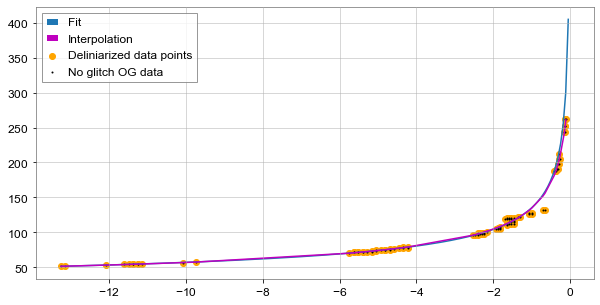

In [711]:
import pandas as pd
# Assign variables to the arrays
## interpolation
t_interp = l_interp[0]
f_interp = l_interp[1]

## Curve_fit
t = np.linspace(min(t_new), -0.05, num=200)
f_fit = fit(t, *l_popt_fit)

# Calculate the multiplyier factor for the frequency arrays
delinearized_frequency_for_factor = li_freq2**(-3/8)
scale_factor_cf = (max(freq_new) / (max(delinearized_frequency_for_factor)))

# Create data frame for the frequency fit
df_fit = pd.DataFrame({'time': t, 'frequency': f_fit})

# De-linearize the frequency
df_fit['frequency'] = scale_factor_cf * df_fit['frequency']**(-3/8)               ### 'Curve_fit'

real_delinearized_frequency = scale_factor_cf * delinearized_frequency_for_factor ### Data that was 'linearized' and then 'delinearized'

f_interp = f_interp**(-3/8)                                        ### Interpolation

# -------------------------------------------------------------------------------  

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_fit['time'], df_fit['frequency'],  label="Fit")
ax.plot(t_interp, f_interp,'m', label='Interpolation')
ax.scatter(t_new, real_delinearized_frequency, color="orange", label="Deliniarized data points")
ax.scatter(t_new, freq_new, s=1, color="black", label="No glitch OG data")
ax.legend(loc='best')

plt.show()

# ------------------------------------------------------------------------------

# Assign variables to DF columnds
f_fit = df_fit['frequency']  ##(np.pi * (l_cm_fit * ((1+1)**2 / 1)**(3/5)) * df_fit['frequency'])**(1/3)
t_fit = df_fit['time']

### 3.2 Lambda fit
To obtain the desired units, we have to do some unit conversions

* **From solar mass to seconds for the Mass and reduced mass:**

    Having that $M_{\odot} = 1.989x10^{30} \ kg$ and $\frac{G}{c^{3}}=2.477100x10^{36} \ \frac{s}{kg}$ we obtain:

$$Conversion \ factor(M_{\odot} \rightarrow s) = M_{\odot}\frac{G}{c^{3}} = 4.926952755x10^{-6} s$$

* **From $s^{5}$ to $10^{36} \ g \ cm^{2} \ s^{2}$:**

    Having that $c^{5} = 2.42160617x10^{52} \ \frac{{cm}^{5}}{s^{5}}$ and $G = 6.6743x10^8 \ \frac{{cm}^{3}}{gs^{2}}$ we obtain:
    
    $$Conversion \ factor(s^{5} \rightarrow 10^{36} \ g \ cm^{2} \ s^{2}) = ({10}^{36})(\frac{c^{5}}{G})$$

In [712]:
# Setting Constants
gamma = np.euler_gamma

# Define fitting function
def lamb_fit(f, cm, q=1, beta=0, sigma=0, lambda_tilde=0):
    ## Conversion from solar mass to s
    G_c3 = 4.926952755e-6   ## s / solar mass
    chirp = cm * G_c3
    
    ## Conversion from s^5 to 10^36 g cm^2 s^2
    c5 = 2.42160617e52
    G_cm = 6.6743e-8
    
    lambda_tilde = lambda_tilde * (10**36) * (G_cm/c5)
    
    ## Get total mass and reduced mass
    M = chirp * ((1+q)**2 / q)**(3/5)     ### Total mass
    mu = (chirp * M**(-2/5))**(5/3)       ### Reduced mass
    #mu = cm * q**0.4 / (1+q)**0.8 * G_over_c_cubed
    #M = cm * (1+q)**1.2 / q**0.6 * G_over_c_cubed
    
    ## Define v
    v = np.cbrt(np.pi * M * f)
    
    ## Simplyfing by condensing equation
    r = 3 * M / (128 * mu)
    
    a_v2 = (20/9) * (743/336 + (11/4 * mu/M))
    a_v3 = 4 * (4*np.pi - beta)
    a_v4 = 10 * (3058673/1016064 + (5429/1008 * mu/M) + (617/144 * mu**2/M**2) - sigma)
    a_v5 = (38645*np.pi / 252 - (65/3 * mu/M))

    a_v6 = (11583231236531/4694215680 - 640*(np.pi**2)/3 - 6848*gamma/21)
    a_v6_2 = mu/M * (153355978/30481 + 2255*(np.pi**2)/12 + 47324/63 - 7948/9)
    a_v6_3 = ((76055/1728 * mu**2/M**2) - (127825/1296 * mu**3/M**3))
    a_v6_3_ln_4v = -6848/21                                                       ### This is the np.log(4*v) * v**6 log term

    a_v7 = np.pi * (77096675/254016 + (378515/1512 * mu/M) - (74045/756 * mu**2/M**2))
    
    a_del_psi = -9 * 26 / (16 * mu * M**4)
    
    ## Derivatives
    
    dev_phase = r * (-5/v**6 - 3*a_v2/v**4 + 2*a_v3/v**3 - a_v4/v**2 + a_v5/v +
                     (a_v6 + a_v6_2 + a_v6_3) + a_v6_3_ln_4v*(1 + np.log(4*v)) + 2*a_v7*v) * (np.pi*M / (3 * v**2))
    
    dev_lamb_term = (5 * a_del_psi * lambda_tilde * v**4) * (np.pi*M / (3 * v**2))
    
    ## Complete derivative of phase
    phase = (dev_phase + dev_lamb_term) / (2 * np.pi)
    
    return phase
               
# Bounds of the function
bounds = ((0,-1,0),(50,1,np.inf))

# Perform the least squares fitting 
#l_popt_lq, l_pcov_lq = curve_fit(lambda f, lambda_tilde, cm, t_c: lamb_fit(f,lambda_tilde, cm, t_c, q=1, beta=0, sigma=0),
                               #freq_new, t_new, absolute_sigma=False) #, bounds=bounds

# Find the standard errors
#lamb_fit_errors = np.sqrt(np.diag(l_pcov_lq))

# Print results
#print("The tidal deformability is",l_popt_lq[0] , u"\u00B1", lamb_fit_errors[0], "(10^36 g cm^2 s^2) \n")
#print("The chirp mass is", l_popt_lq[1], u"\u00B1", lamb_fit_errors[1], "Solar masses \n")
#print("tc is", l_popt_lq[2],u"\u00B1", lamb_fit_errors[2])


**First Order Fit**

In [713]:
# Function for first order
t_first = lambda f, cm, tc: tc + lamb_fit(f, cm)

popt_first, pcov_first = curve_fit(t_first, freq_new, t_new)

# Print results
print("The chirp mass is", popt_first[0], u"\u00B1", np.sqrt(pcov_first[0][0]), "Solar masses \n")
print("The coalescence time tc is", popt_first[1],u"\u00B1", np.sqrt(pcov_first[1][1]))

The chirp mass is 1.2026647809695992 ± 0.0030764056109356297 Solar masses 

The coalescence time tc is -0.002558172195310396 ± 0.02108435936380567


**All the function**

In [714]:
# Bound fit
t_bound = lambda f, cm, tc, lambda_tilde: tc + lamb_fit(f, cm, lambda_tilde=lambda_tilde)

popt_bound, pcov_bound = curve_fit(t_all, freq_new, t_new, sigma=1/l_energy, absolute_sigma=False, bounds=bounds)

# Fit without Bounds
t_nobound = lambda f, cm, tc, lambda_tilde: tc + lamb_fit(f, cm, lambda_tilde=lambda_tilde)

popt_nobound, pcov_nobound = curve_fit(t_all, freq_new, t_new, sigma=1/l_energy, absolute_sigma=False)

In [759]:
# Print results
print("Fit with Bounds:")
print("The chirp mass is", popt_bound[0], u"\u00B1", np.sqrt(pcov_bound[0][0]), "Solar masses")
print("The coalescence time tc is", popt_bound[1],u"\u00B1", np.sqrt(pcov_bound[1][1]))
print("The tidal deformability is", popt_bound[2], u"\u00B1", np.sqrt(pcov_bound[2][2]), "(10^36 g cm^2 s^2) \n")

print("Fit withput Bounds:")
print("The chirp mass is", popt_nobound[0], u"\u00B1", np.sqrt(pcov_nobound[0][0]), "Solar masses")
print("The coalescence time tc is", popt_nobound[1],u"\u00B1", np.sqrt(pcov_nobound[1][1]))
print("The tidal deformability is", popt_nobound[2], u"\u00B1", np.sqrt(pcov_nobound[2][2]), "(10^36 g cm^2 s^2) \n")

## Print Variances for final result:
print("---------------------------------------------------------------------------------------- \n")
print("Bound lambda:", pcov_bound[2][2])
print("lambda:", pcov_nobound[2][2], "\n")
print("Bound CM:", pcov_bound[0][0])
print('CM:', pcov_nobound[0][0], "\n")

## Upper limit results
print("---------------------------------------------------------------------------------------- \n")
print("Bound lambda upper limit:", popt_bound[2]/26 + (1.644854 * np.sqrt(pcov_bound[2][2])/26), "(10^36 g cm^2 s^2) \n")
print("lambda:", popt_nobound[2]/26 + np.sqrt(pcov_nobound[2][2])/26, "(10^36 g cm^2 s^2) \n")

Fit with Bounds:
The chirp mass is 1.2060227039453786 ± 0.005542195244238193 Solar masses
The coalescence time tc is -0.03720621457962394 ± 0.10929233786779498
The tidal deformability is 8.789459392460657e-16 ± 831.8262366387554 (10^36 g cm^2 s^2) 

Fit withput Bounds:
The chirp mass is 1.2111270981907618 ± 0.005563629964613158 Solar masses
The coalescence time tc is -0.16609182257784175 ± 0.10848870492030348
The tidal deformability is -1012.9233715498486 ± 849.2735427633372 (10^36 g cm^2 s^2) 

---------------------------------------------------------------------------------------- 

Bound lambda: 691934.8879605946
lambda: 721265.55043779 

Bound CM: 3.071592812525644e-05
CM: 3.095397838314141e-05 

---------------------------------------------------------------------------------------- 

Bound lambda upper limit: 52.62433510154628 (10^36 g cm^2 s^2) 

lambda: -6.294224184096592 (10^36 g cm^2 s^2) 



In [716]:
# Define frequency range
f_range_fit = np.linspace(min(freq_new), 400, num=100)

# Assign variables to the parameters
chirp_mass_b, tc_b, lambda_tilde_b = popt_bound

chirp_mass_nob, tc_nob, lambda_tilde_nob = popt_nobound

# Find error bands (Borrowed from Felix code)
## With Bounds
err_plus_b = t_bound(f_range_fit, *(popt_bound+[-np.sqrt(pcov_bound[0][0]),
                                                -np.sqrt(pcov_bound[1][1]), np.sqrt(pcov_bound[1][1])]))

err_minus_b = t_bound(f_range_fit, *(popt_bound-[-np.sqrt(pcov_bound[0][0]),
                                                 -np.sqrt(pcov_bound[1][1]), np.sqrt(pcov_bound[1][1])]))
## Without bounds
err_plus_nob = t_nobound(f_range_fit, *(popt_nobound+[-np.sqrt(pcov_nobound[0][0]),
                                                -np.sqrt(pcov_nobound[1][1]), np.sqrt(pcov_nobound[1][1])]))

err_minus_nob = t_nobound(f_range_fit, *(popt_nobound-[-np.sqrt(pcov_nobound[0][0]),
                                                 -np.sqrt(pcov_nobound[1][1]), np.sqrt(pcov_nobound[1][1])]))

C:\Users\erick\anaconda3\lib\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)
C:\Users\erick\anaconda3\lib\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


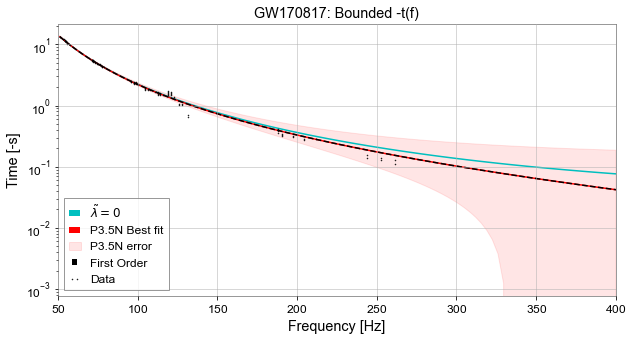

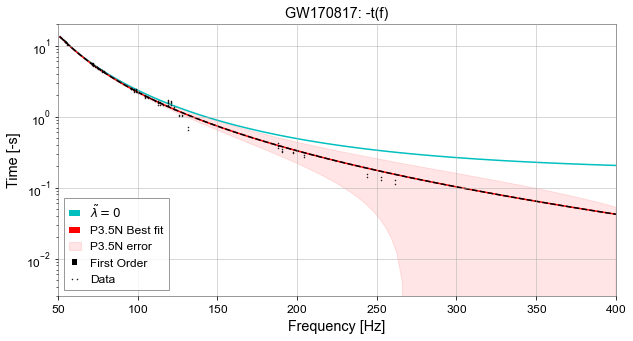

In [717]:
# Plot the results
## With bounds
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(f_range_fit, -t_bound(f_range_fit, chirp_mass_b, tc_b, 0), 'c-',markersize=1, label = r"$\tilde{\lambda}=0$")

ax.plot(f_range_fit, -t_bound(f_range_fit, *popt_all), 'r-',markersize=4, label = "P3.5N Best fit")
ax.fill_between(f_range_fit, -err_minus_b, -err_plus_b, alpha=0.1, edgecolor='r', facecolor='r', label = "P3.5N error")

ax.plot(f_range_fit, -t_first(f_range_fit, *popt_first), 'k--',markersize=1, label = "First Order")
#ax.plot(f_fit, -t_fit,'k--', markersize=1, label = "Chirp Mass Equation")
ax.plot(freq_new , -t_new, 'k.', markersize=1, label="Data")
ax.set_title("GW170817: Bounded -t(f)")
ax.set_yscale('log')
ax.set_ylabel('Time [-s]')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(50, 400)
#ax.grid(True, axis='y', which='both')
ax.legend(loc='lower left')

plot.show()

## Without bounds
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(f_range_fit, -t_nobound(f_range_fit, chirp_mass_nob, tc_nob, 0), 'c-',markersize=1, label = r"$\tilde{\lambda}=0$")

ax.plot(f_range_fit, -t_nobound(f_range_fit, *popt_all), 'r-',markersize=4, label = "P3.5N Best fit")
ax.fill_between(f_range_fit, -err_minus_nob, -err_plus_nob, alpha=0.1, edgecolor='r', facecolor='r', label = "P3.5N error")

ax.plot(f_range_fit, -t_first(f_range_fit, *popt_first), 'k--',markersize=1, label = "First Order")
#ax.plot(f_fit, -t_fit,'k--', markersize=1, label = "Chirp Mass Equation")

ax.plot(freq_new , -t_new, 'k.', markersize=1, label="Data")

ax.set_title("GW170817: -t(f)")
ax.set_yscale('log')
ax.set_ylabel('Time [-s]')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(50, 400)
#ax.grid(True, axis='y', which='both')
ax.legend(loc='lower left')

plot.show()

### 3.3 Dimensionless tidal deformability (Work in Progress)

[GW170814: A Three-Detector Observation of Gravitational Waves from a Binary Black Hole Coalescence](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.141101) gives an upper bound to the dimensionles weighted lambda deformabitlity $\overset{\sim}{\Lambda} \leq 800$ for low-spin priors $|\chi| \leq 0.05$, and an upper bound of $\overset{\sim}{\Lambda} \leq 1400$ for high-spin priors $|\chi| \leq 0.89$.

We can obtain the dimensionless weigthed tidal deformability by converting $\overset{\sim}{\lambda}$ back into units of $s^5$ and then using the following equation *(Taken from Felix's work)*

$$\overset{\sim}{\Lambda} = \frac{16}{13} \frac{\overset{\sim}{\lambda}}{M^{5}}$$

Given that we choose the mass ratio $q = 1$ the weighted tidal deformability converges $\overset{\sim}{\lambda} \rightarrow \lambda$ and we can find the the dimensionless $\overset{\sim}{\Lambda} \rightarrow \Lambda$ as

$$\Lambda = \frac{\lambda}{M^{5}}$$


**Bound case:**

In [735]:
# Assign variable to lambda error
lambda_tilde_b_err = np.sqrt(pcov_bound[2][2])
chirp_mass_b_err = np.sqrt(pcov_bound[2][2])

# lambda conversion back to s^5
c5 = 2.42160617e52
G_cm = 6.6743e-8

lambda_tilde = lambda_tilde_b / ((10**36) * (G_cm/c5))  # From cgs to s^5 
lambda_tilde_err = lambda_tilde_b_err / ((10**36) * (G_cm/c5))

# Convert chirp mass from solar masses to s^5
chirp_mass_b = chirp_mass_b*4.926952755e-6

# Total Mass in s^5 and error 
q=1                                                                        ### q changes depending the value we choose!!
M = chirp_mass_b * ((1+q)**2 / q)**(3/5)
M_err = chirp_mass_b_err * ((1+q)**2 / q)**(3/5)

# Dimensionless Lambda
dless_Lambda_b = lambda_tilde / M**5

# Error propagation
dless_Lambda_b_err = np.sqrt((lambda_tilde_err / M**5)**2 + (-5*lambda_tilde*M_err / M**6)**2)

# Results
print("The dimensionless tidal deformability is:", dless_Lambda_b, u"\u00B1", dless_Lambda_b_err, "\n")

# Upper limit
print("The upper limit for the bounded lambda is:", dless_Lambda_b + dless_Lambda_b_err)

The dimensionless tidal deformability is: 6.726831875573305e+32 ± 6.366210928011644e+50 

The upper limit for the bounded lambda is: 6.366210928011644e+50


I have yet to calculate the errors but comparing with Felix result: -36702
* Same order of magnite but different sign? Also I got this value By forcing lambda to be + while felix's value is for the unbounded case!!
* My error is astronomically larger than what he calculated, maybe I made a mistake? Go back
* Aaaaaaa I had a value of 35000 but I movced something and now its not working :(

**Unbound case**

In [737]:
# Assign variable to lambda error
lambda_tilde_nob_err = np.sqrt(pcov_nobound[2][2])
chirp_mass_nob_err = np.sqrt(pcov_nobound[2][2])

# lambda conversion back to s^5
c5 = 2.42160617e52
G_cm = 6.6743e-8
lambda_tilde = lambda_tilde_nob / ((10**36) * (G_cm/c5))  # From cgs to s^5 
lambda_tilde_err = lambda_tilde_nob_err / ((10**36) * (G_cm/c5))

# Total Mass in s^5         
q=1                                ### q changes depending the value we choose!!

M = chirp_mass_nob * ((1+q)**2 / q)**(3/5)
M_err = chirp_mass_nob_err * ((1+q)**2 / q)**(3/5)

# Dimensionless Lambda
dless_Lambda_nob = lambda_tilde / M**5

# Error propagation
dless_Lambda_nob_err = np.sqrt((lambda_tilde_err / M**5)**2 + (-5*lambda_tilde*M_err / M**6)**2)

# Results
print("The dimensionless tidal deformability is:", dless_Lambda_nob, u"\u00B1",dless_Lambda_nob_err, "\n")

# Upper limit
print("The upper limit for Lambda is:", dless_Lambda_nob + dless_Lambda_nob_err)

The dimensionless tidal deformability is: -2.2036661582089664e+24 ± 7.726337811933074e+27 

The upper limit for Lambda is: 7.724134145774865e+27


### 3.4 Calculate the love number k2

**Bound case:**

**Unbound case:**

# Plot for the slide

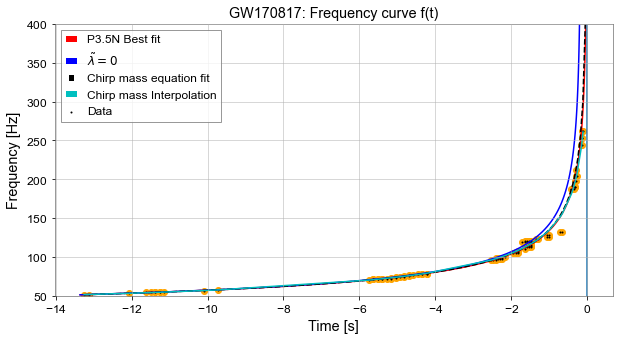

In [733]:
#
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_nobound(f_range_fit, *popt_all), f_range_fit, 'r-',markersize=6, label = "P3.5N Best fit")

ax.plot(t_nobound(f_range_fit, chirp_mass_nob, tc_nob, 0), f_range_fit, 'b-',markersize=1, label = r"$\tilde{\lambda}=0$")

ax.plot(df_fit['time'], df_fit['frequency'],'k--', markersize=1, label="Chirp mass equation fit")

ax.plot(t_interp, f_interp,'c', label='Chirp mass Interpolation')

ax.scatter(t_new, real_delinearized_frequency, color="orange")
ax.scatter(t_new, freq_new, s=1, color="black", label="Data")
ax.set_title("GW170817: Frequency curve f(t)")
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
ax.vlines(x=0, ymin=0, ymax=400)
ax.legend(loc='best')
ax.set_ylim(50, 400)

plt.show()

In [758]:
### Use Felix code for Lambda
solar_mass = 1.989e+30 

# calculate and print dimensionless tidal deformability Lambda + error
from scipy.constants import c # m/s
from scipy.constants import G # m^3 kg^-1 s^-2
#
L_kg = popt_bound[2] * 10e36 * 1e-7  # g cm^2 s^2 -> kg m^2 s^2
L_err_kg = np.sqrt(pcov_bound[2][2])/26 * 1e-7  # g cm^2 s^2 -> kg m^2 s^2

# Lambda
q = 1
M_full = ((1+q)**2/q)**(3/5) * (1.2111270981907618 * solar_mass) * G/c**2 # kg -> m

lambda_tilde_full = L_kg/26 * G * 10e36 # kg m^2 s^2 -> m^5

Lambda_full = 16/13*lambda_tilde_full/M_full**5

# error propagation
M_full_err = ((1+q)**2/q)**(3/5) * (0.005563629964613158 * solar_mass)* G/c**2 # kg -> m

lambda_tilde_full_err = L_err_kg * G * 10e36 # kg m^2 s^2 -> m^5

Lambda_full_err = np.sqrt( (16/13/M_full**5 * lambda_tilde_full_err)**2 
                          +(-80/13*lambda_tilde_full/M_full**6 * M_full_err)**2)
# Result
print("Lambda:", Lambda_full)
print("Lambda error:", Lambda_full_err)
print("Upper limit:", Lambda_full + Lambda_full_err)

Lambda: 2.368356550340634e+22
Lambda error: 5.439833478272806e+20
Upper limit: 2.4227548851233618e+22
